In [21]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    log_loss
)
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

2. loading dataset

In [14]:
def load_dataset(dataset_dir):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))
    for label_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            img_path = os.path.join(class_dir, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue
            images.append(img)
            labels.append(label_idx)
    return images, labels, class_names

train_dir = "./Aerial_Landscapes_split/train" 
test_dir = "./Aerial_Landscapes_split/test"
train_images, train_labels, class_names = load_dataset(train_dir)
test_images, test_labels, _ = load_dataset(test_dir)

print(f"Train samples: {len(train_images)}, Classes: {class_names}")

Train samples: 9600, Classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


3. LBP extracting features

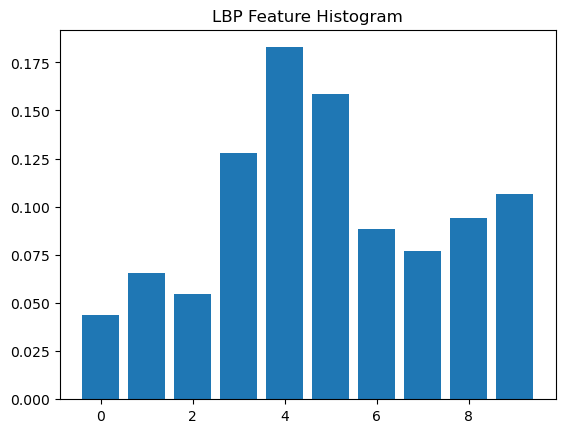

In [ ]:
def extract_lbp_features(image, num_points=8, radius=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, num_points, radius, method="uniform")
    n_bins = int(num_points + 2)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# draw LBP feature histogram
sample_img = train_images[0]
lbp_feat = extract_lbp_features(sample_img)
plt.bar(range(len(lbp_feat)), lbp_feat)
plt.title("LBP Feature Histogram")
plt.show()



4. SIFT extract features and BoW

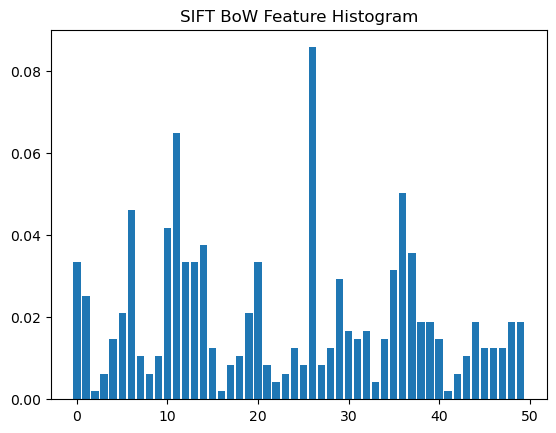

In [ ]:
def extract_sift_descriptors(image, sift):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

def build_vocabulary(descriptor_list, vocab_size):
    all_descriptors = np.vstack(descriptor_list)
    kmeans = MiniBatchKMeans(n_clusters=vocab_size, batch_size=2560, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans

def extract_bow_feature(image, sift, kmeans, vocab_size):
    descriptors = extract_sift_descriptors(image, sift)
    if descriptors is None:
        return np.zeros(vocab_size)
    words = kmeans.predict(descriptors)
    hist, _ = np.histogram(words, bins=np.arange(vocab_size + 1))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# Extract SIFT descriptors from training images and build the visual vocabulary
sift = cv2.SIFT_create()
descriptor_list = []
for img in train_images:
    des = extract_sift_descriptors(img, sift)
    if des is not None:
        descriptor_list.append(des)

vocab_size = 50  # Size of the vocabulary
if len(descriptor_list) > 0:
    kmeans = build_vocabulary(descriptor_list, vocab_size)
else:
    print("No SIFT descriptors detected, please check the data!")

# Test extracting BoW features
bow_feat = extract_bow_feature(sample_img, sift, kmeans, vocab_size)
plt.bar(range(len(bow_feat)), bow_feat)
plt.title("SIFT BoW Feature Histogram")
plt.show()

5.  Train classifier (SVM)

In [ ]:
def get_features(images, method, **kwargs):
    feats = []
    if method == 'lbp':
        for img in images:
            feats.append(extract_lbp_features(img, kwargs.get('num_points', 8), kwargs.get('radius', 1)))
    elif method == 'sift':
        for img in images:
            feats.append(extract_bow_feature(img, kwargs.get('sift'), kwargs.get('kmeans'), kwargs.get('vocab_size')))
    return np.array(feats)

n_epochs = 50  # training epoch

LBP

=== LBP Method ===
LBP Epoch 01/50, Loss: 3.7846, Train Acc: 0.3505, Test Acc: 0.3521
LBP Epoch 02/50, Loss: 2.4090, Train Acc: 0.3442, Test Acc: 0.3387
LBP Epoch 03/50, Loss: 2.1305, Train Acc: 0.3549, Test Acc: 0.3488
LBP Epoch 04/50, Loss: 2.0100, Train Acc: 0.3730, Test Acc: 0.3688
LBP Epoch 05/50, Loss: 1.9325, Train Acc: 0.3878, Test Acc: 0.3796
LBP Epoch 06/50, Loss: 1.8831, Train Acc: 0.4009, Test Acc: 0.3921
LBP Epoch 07/50, Loss: 1.8526, Train Acc: 0.4055, Test Acc: 0.3962
LBP Epoch 08/50, Loss: 1.8313, Train Acc: 0.4134, Test Acc: 0.4008
LBP Epoch 09/50, Loss: 1.8148, Train Acc: 0.4196, Test Acc: 0.4042
LBP Epoch 10/50, Loss: 1.8012, Train Acc: 0.4229, Test Acc: 0.4025
LBP Epoch 11/50, Loss: 1.7896, Train Acc: 0.4280, Test Acc: 0.4075
LBP Epoch 12/50, Loss: 1.7794, Train Acc: 0.4311, Test Acc: 0.4104
LBP Epoch 13/50, Loss: 1.7705, Train Acc: 0.4356, Test Acc: 0.4142
LBP Epoch 14/50, Loss: 1.7627, Train Acc: 0.4376, Test Acc: 0.4154
LBP Epoch 15/50, Loss: 1.7558, Train Acc: 0

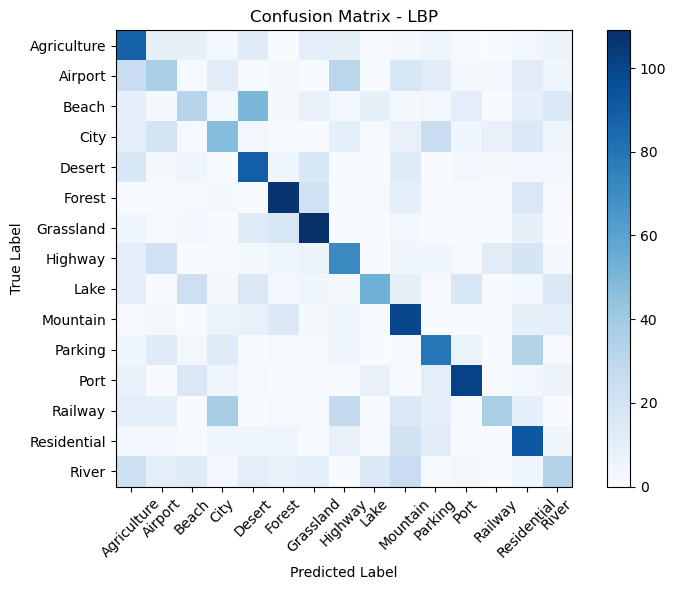

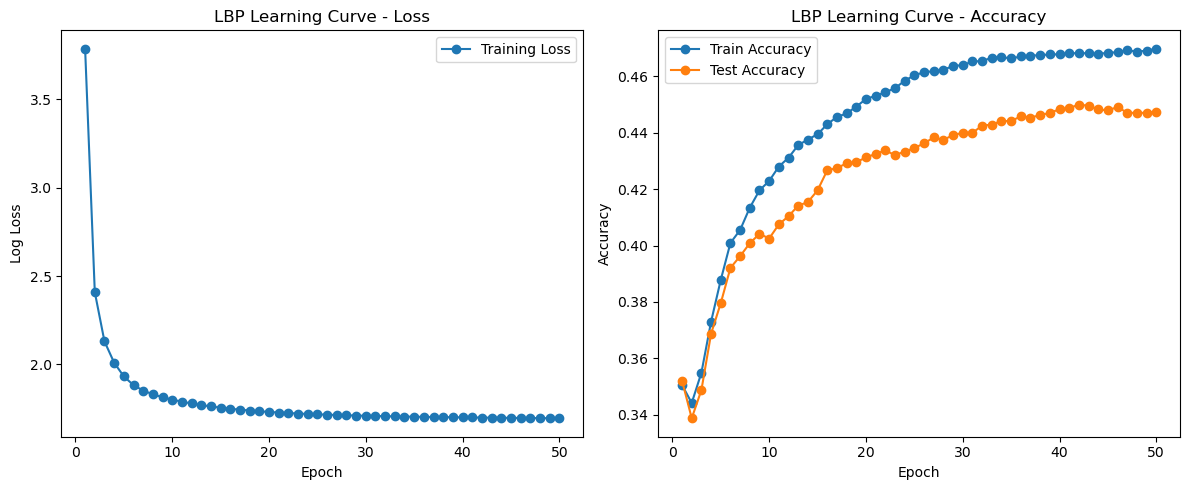

In [ ]:
###########################################
# LBP method
###########################################
print("=== LBP Method ===")
# LBP features
X_train_lbp = get_features(train_images, method="lbp", num_points=8, radius=1)
X_test_lbp = get_features(test_images, method="lbp", num_points=8, radius=1)

# StandardScaler
scaler_lbp = StandardScaler()
X_train_lbp_scaled = scaler_lbp.fit_transform(X_train_lbp)
X_test_lbp_scaled = scaler_lbp.transform(X_test_lbp)

# Iterative training using SGDClassifier (logistic loss) to record learning curves
lbp_train_loss = []
lbp_train_acc = []
lbp_test_acc = []

lbp_clf = SGDClassifier(loss="log_loss", random_state=42)
classes_array = np.unique(train_labels)
for epoch in range(n_epochs):
    lbp_clf.partial_fit(X_train_lbp_scaled, train_labels, classes=classes_array)
    prob_train = lbp_clf.predict_proba(X_train_lbp_scaled)
    loss = log_loss(train_labels, prob_train)
    lbp_train_loss.append(loss)

    train_acc = accuracy_score(train_labels, lbp_clf.predict(X_train_lbp_scaled))
    test_acc = accuracy_score(test_labels, lbp_clf.predict(X_test_lbp_scaled))
    lbp_train_acc.append(train_acc)
    lbp_test_acc.append(test_acc)
    print(
        f"LBP Epoch {epoch+1:02d}/{n_epochs}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}"
    )

# classification report
y_pred_lbp = lbp_clf.predict(X_test_lbp_scaled)
acc_lbp = accuracy_score(test_labels, y_pred_lbp)
print("\nFinal LBP Accuracy: {:.2f}%".format(acc_lbp * 100))
print("LBP Classification Report:")
print(classification_report(test_labels, y_pred_lbp, target_names=class_names))

# confusion matrix
cm_lbp = confusion_matrix(test_labels, y_pred_lbp)
plt.figure(figsize=(8, 6))
plt.imshow(cm_lbp, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LBP")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# LBP Learning curves (loss/accuracy vs. epochs)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), lbp_train_loss, label="Training Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("LBP Learning Curve - Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), lbp_train_acc, label="Train Accuracy", marker="o")
plt.plot(range(1, n_epochs + 1), lbp_test_acc, label="Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LBP Learning Curve - Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

SIFT


=== SIFT Method ===
SIFT Epoch 01/50, Loss: 13.8536, Train Acc: 0.4315, Test Acc: 0.4117
SIFT Epoch 02/50, Loss: 10.9482, Train Acc: 0.4142, Test Acc: 0.4008
SIFT Epoch 03/50, Loss: 8.1694, Train Acc: 0.4118, Test Acc: 0.3912
SIFT Epoch 04/50, Loss: 6.5382, Train Acc: 0.4054, Test Acc: 0.3921
SIFT Epoch 05/50, Loss: 5.1906, Train Acc: 0.4183, Test Acc: 0.3967
SIFT Epoch 06/50, Loss: 4.3960, Train Acc: 0.4149, Test Acc: 0.3996
SIFT Epoch 07/50, Loss: 3.8975, Train Acc: 0.4179, Test Acc: 0.3950
SIFT Epoch 08/50, Loss: 3.6019, Train Acc: 0.4167, Test Acc: 0.3987
SIFT Epoch 09/50, Loss: 3.3485, Train Acc: 0.4196, Test Acc: 0.4021
SIFT Epoch 10/50, Loss: 3.0519, Train Acc: 0.4314, Test Acc: 0.4000
SIFT Epoch 11/50, Loss: 2.9406, Train Acc: 0.4254, Test Acc: 0.4067
SIFT Epoch 12/50, Loss: 2.7381, Train Acc: 0.4322, Test Acc: 0.4142
SIFT Epoch 13/50, Loss: 2.6596, Train Acc: 0.4370, Test Acc: 0.4188
SIFT Epoch 14/50, Loss: 2.4948, Train Acc: 0.4399, Test Acc: 0.4217
SIFT Epoch 15/50, Loss: 2

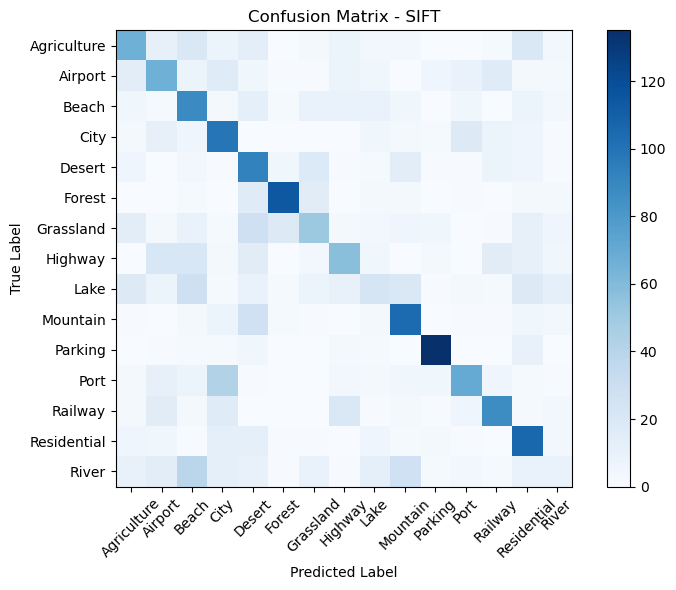

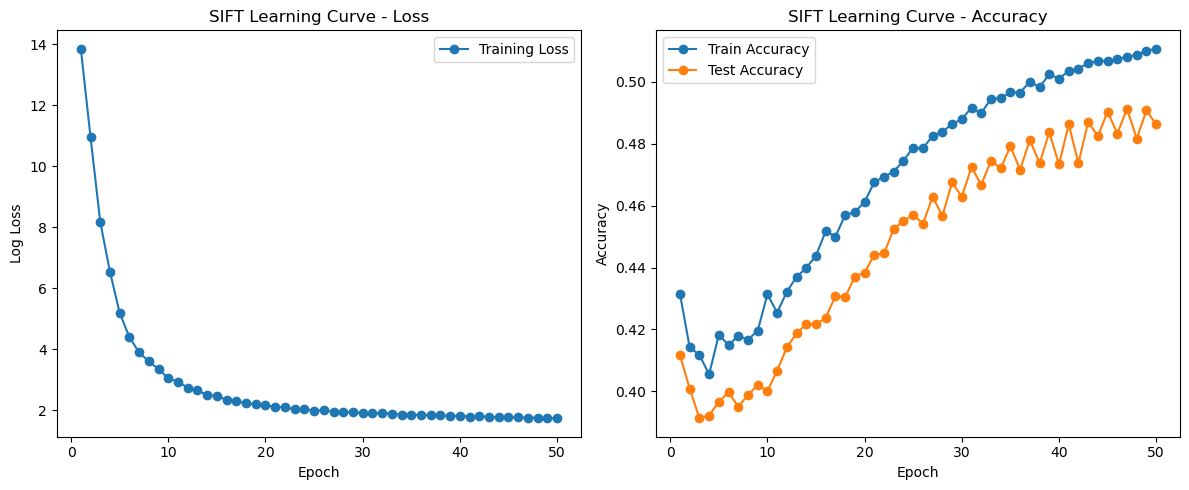

In [ ]:
###########################################
# SIFT Method (BoW)
###########################################
print("\n=== SIFT Method ===")

sift = cv2.SIFT_create()
X_train_sift = get_features(
    train_images, method="sift", sift=sift, kmeans=kmeans, vocab_size=vocab_size
)
X_test_sift = get_features(
    test_images, method="sift", sift=sift, kmeans=kmeans, vocab_size=vocab_size
)

# StandardScaler
scaler_sift = StandardScaler()
X_train_sift_scaled = scaler_sift.fit_transform(X_train_sift)
X_test_sift_scaled = scaler_sift.transform(X_test_sift)

sift_train_loss = []
sift_train_acc = []
sift_test_acc = []

sift_clf = SGDClassifier(loss="log_loss", random_state=42)
for epoch in range(n_epochs):
    sift_clf.partial_fit(X_train_sift_scaled, train_labels, classes=classes_array)
    prob_train = sift_clf.predict_proba(X_train_sift_scaled)
    loss = log_loss(train_labels, prob_train)
    sift_train_loss.append(loss)

    train_acc = accuracy_score(train_labels, sift_clf.predict(X_train_sift_scaled))
    test_acc = accuracy_score(test_labels, sift_clf.predict(X_test_sift_scaled))
    sift_train_acc.append(train_acc)
    sift_test_acc.append(test_acc)
    print(
        f"SIFT Epoch {epoch+1:02d}/{n_epochs}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}"
    )

# classification report
y_pred_sift = sift_clf.predict(X_test_sift_scaled)
acc_sift = accuracy_score(test_labels, y_pred_sift)
print("\nFinal SIFT Accuracy: {:.2f}%".format(acc_sift * 100))
print("SIFT Classification Report:")
print(classification_report(test_labels, y_pred_sift, target_names=class_names))

# confusion matrix
cm_sift = confusion_matrix(test_labels, y_pred_sift)
plt.figure(figsize=(8, 6))
plt.imshow(cm_sift, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SIFT")
plt.colorbar()
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# SIFT Learning curves (loss/accuracy vs. epochs)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), sift_train_loss, label="Training Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("SIFT Learning Curve - Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), sift_train_acc, label="Train Accuracy", marker="o")
plt.plot(range(1, n_epochs + 1), sift_test_acc, label="Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("SIFT Learning Curve - Accuracy")
plt.legend()

plt.tight_layout()
plt.show()